In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from cntxt import rom_am
from rom_am import ROM
import matplotlib.pyplot as plt

In [2]:
import scipy.io
mat = scipy.io.loadmat('../DATA/CYLINDER_ALL.mat',)
nx = 449
ny = 199

## X Velocity reduction

In [5]:
X = mat["UALL"]

In [6]:
pod = ROM(rom="pod")
pod.decompose(X, alg="snap",)

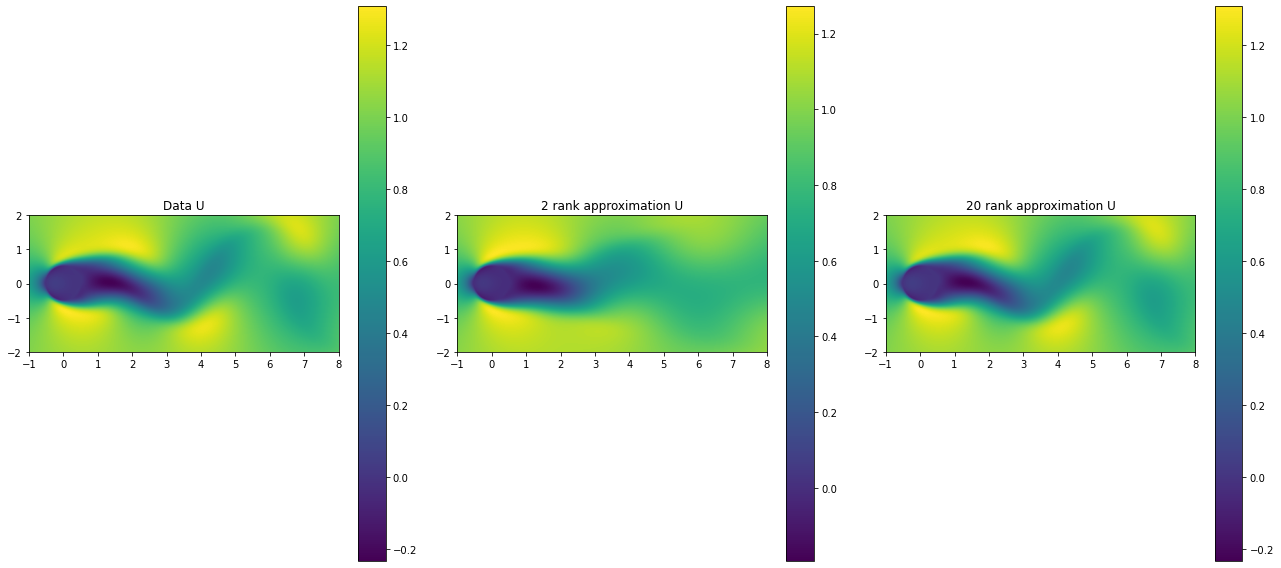

In [7]:
rank1 = 2
rank2 = 20


fig, ax  = plt.subplots(1, 3, figsize = (18, 8))
im = ax[0].imshow(X[:, 0].reshape((ny, nx), order = 'F'), extent=[-1, 8, -2, 2]);
fig.colorbar(im, ax=ax[0]);
ax[0].set_title("Data U");

im = ax[1].imshow(pod.approximate(rank1)[:, 0].reshape((ny, nx), order = 'F'), extent=[-1, 8, -2, 2]);
fig.colorbar(im, ax=ax[1]);
ax[1].set_title("{} rank approximation U" .format(rank1));

im = ax[2].imshow(pod.approximate(rank2)[:, 0].reshape((ny, nx), order = 'F'), extent=[-1, 8, -2, 2]);
fig.colorbar(im, ax=ax[2]);
ax[2].set_title("{} rank approximation U" .format(rank2));

fig.tight_layout();

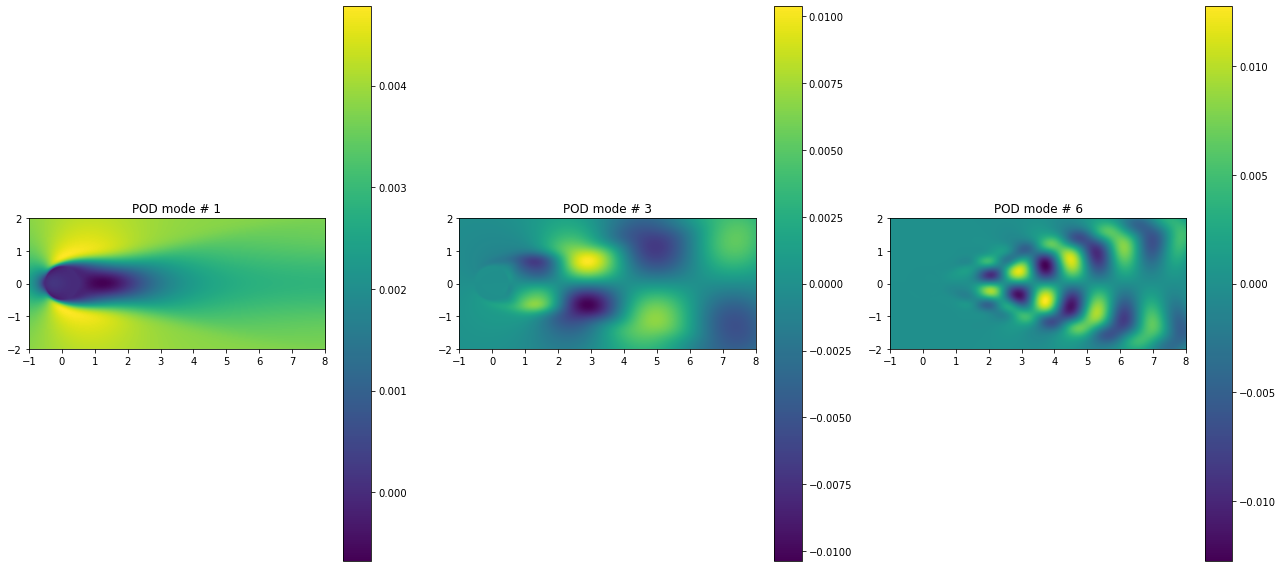

In [8]:
n_mode = [0, 2, 5]

fig, ax  = plt.subplots(1, 3, figsize = (18, 8))

for i in range(len(n_mode)):
    im = ax[i].imshow(pod.modes[:, n_mode[i]].reshape((ny, nx), order = 'F'), extent=[-1, 8, -2, 2]);
    fig.colorbar(im, ax=ax[i]);
    ax[i].set_title("POD mode # {}" .format(n_mode[i]+1));


fig.tight_layout();

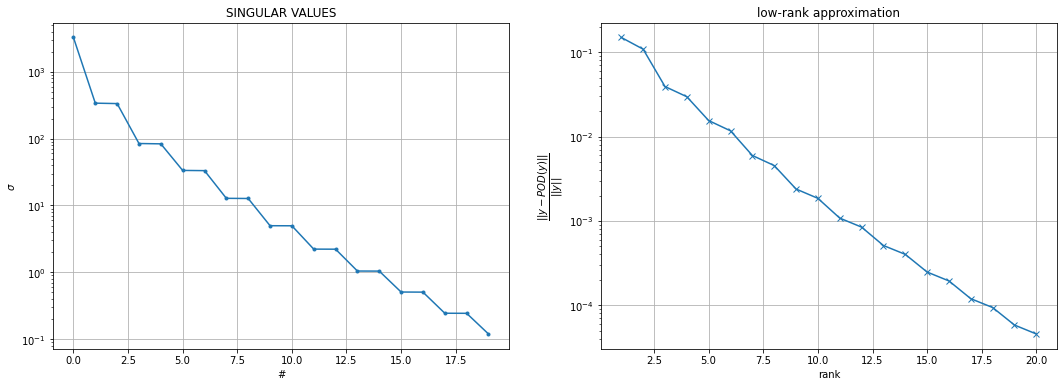

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
y = np.zeros(20)
ranks = np.arange(20)+1
for i in range(20):
    y[i] = np.linalg.norm(X - pod.approximate(i+1))/np.linalg.norm(X)

    
ax[0].semilogy(pod.singvals[:20], '.-')
ax[0].grid();
ax[0].set_ylabel("$\sigma$")
ax[0].set_xlabel("#");
ax[0].set_title("SINGULAR VALUES");

ax[1].semilogy(ranks, y, 'x-')
ax[1].grid();
ax[1].set_ylabel("$\dfrac{||y - POD(y)||}{||y||}$")
ax[1].set_xlabel("rank");
ax[1].set_title("low-rank approximation");

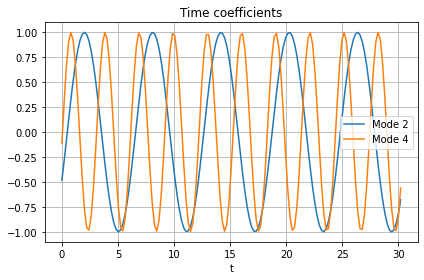

In [10]:
t = np.linspace(0, 151 * .2, 151)
fig = plt.figure()


plt.plot(t, pod.time[1, :]/pod.time[1, :].max(), label = "Mode 2")
plt.plot(t, pod.time[3, :]/pod.time[3, :].max(), label = "Mode 4")
plt.grid();
plt.title("Time coefficients");
plt.xlabel("t");
plt.legend(loc = "best");
plt.tight_layout();

## CPU Time (SVD vs Snapshot)

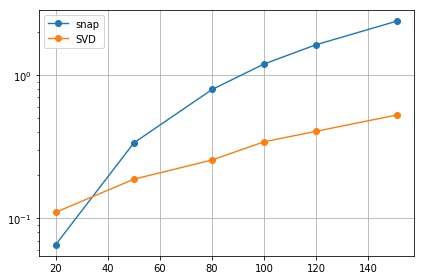

In [9]:
import time
cov_times = []
svd_times = []
sizes = [20, 50, 80, 100, 120, 151]
nt = 5

for s in  sizes:
    t0 = time.time()
    for _ in range (nt):
        pod = ROM(rom="pod")
        pod.decompose(X[:, :s], alg="snap",)
    t1 = time.time()
    cov_times.append((t1 - t0)/nt)

    t0 = time.time()
    for _ in range (nt):
        pod = ROM(rom="pod")
        pod.decompose(X[:, :s], alg="svd",)
    t1 = time.time()
    svd_times.append((t1 - t0)/nt)

plt.semilogy(sizes, cov_times, "o-", label = "snap", linewidth = 1.4);
plt.semilogy(sizes, svd_times, "o-", label = "SVD", linewidth = 1.4);
plt.grid();
plt.legend();
plt.tight_layout();

## Vector Velocity reduction

In [11]:
Y = mat["VALL"]
vector = np.vstack((X, Y))
pod_vector = ROM(rom="pod")
pod_vector.decompose(vector, alg="svd",)

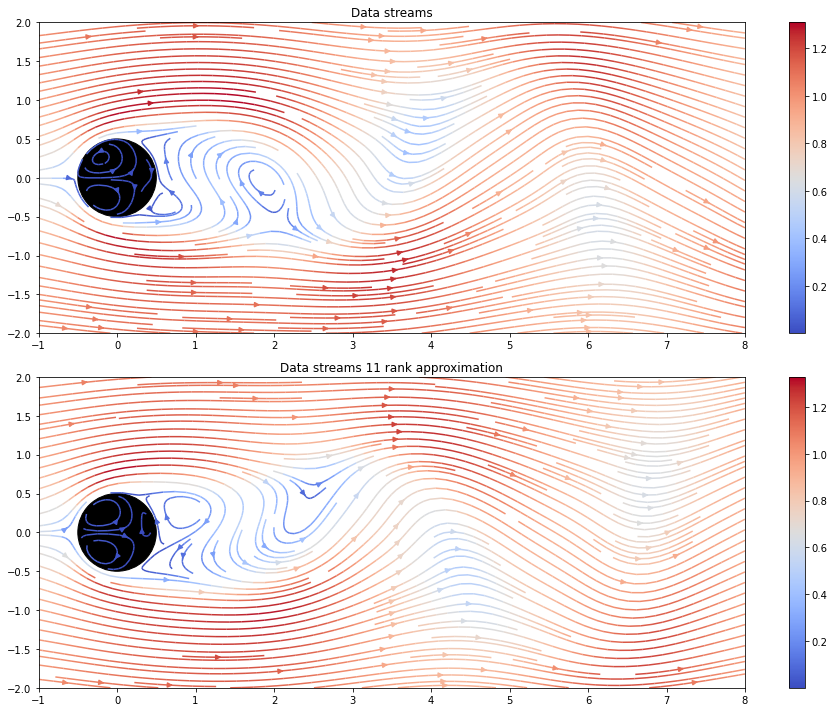

In [12]:
from matplotlib.patches import Circle
rank = 10
instant= 10
xx, yy = np.meshgrid(np.linspace(-1, 8, nx), np.linspace(-2, 2, ny))


fig, ax  = plt.subplots(2, 1, figsize = (13, 10))
uu = X[:, instant].reshape((ny, nx), order = 'F')
vv = Y[:, instant].reshape((ny, nx), order = 'F')
uu[(xx**2+yy**2)<.5**2] = np.nan
vv[(xx**2+yy**2)<.5**2] = np.nan
strm = ax[0].streamplot(xx, yy, uu, vv, color = np.sqrt(uu**2+vv**2), density = 2, cmap = 'coolwarm')
ax[0].set_title("Data streams");
fig.colorbar(strm.lines, ax = ax[0])
ax[0].add_artist(Circle((0, 0), .5, color = "#000000"), )

low_uu = pod_vector.approximate(rank)[:(nx*ny), -1].reshape((ny, nx), order = 'F')
low_vv =  pod_vector.approximate(rank)[(nx*ny)::, -1].reshape((ny, nx), order = 'F')
low_uu[(xx**2+yy**2)<.5**2] = np.nan
low_vv[(xx**2+yy**2)<.5**2] = np.nan
strm = ax[1].streamplot(xx, yy, low_uu, low_vv, color = np.sqrt(low_uu**2+low_vv**2), density = 2, cmap = 'coolwarm')
ax[1].set_title("Data streams {} rank approximation".format(rank+1));
ax[1].add_artist(Circle((0, 0), .5, color = "#000000"), )
fig.colorbar(strm.lines, ax = ax[1])

fig.tight_layout();

## ----------------------------------------------------------------------------------------------------------------------

## DMD Reduction

In [13]:
dmd = ROM("dmd")
dmd.decompose(np.nan_to_num(X[:, :-1], 0), np.nan_to_num(X[:, 1::], 0), dt = .2)

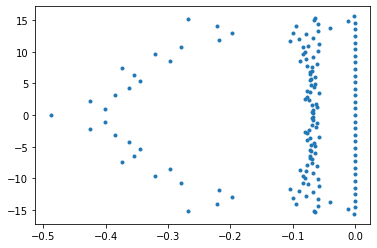

In [17]:
plt.plot(np.real(dmd.eigenvalues), np.imag(dmd.eigenvalues), '.');